In [1]:
from configuration import config
config.pythonpath_fix()

## VQVAE Reconstructions

In [2]:
from ccbir.experiment.experiments import VQVAEExperiment
from ccbir.models.vqvae.model import VQVAE
from ccbir.models.util import load_best_model


"""
vqvae = VQVAE.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_105/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_82/checkpoints/vqvae-morphomnist-epoch=156-val_loss=0.0148636.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_82/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_81/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_79/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_77/checkpoints/vqvae-morphomnist-epoch=688-val_loss=0.0192267.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_76/checkpoints/vqvae-morphomnist-epoch=885-val_loss=0.0260741.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_56/checkpoints/vqvae-morphomnist-epoch=480-val_loss=0.0163195.ckpt' 
)
"""

vqvae = load_best_model(VQVAE)
vqvae_exp = VQVAEExperiment(vqvae)

Loaded <class 'ccbir.models.vqvae.model.VQVAE'> from path=PosixPath('/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/vqvae/best.ckpt')


Loading datamodule...
_z_q.shape=torch.Size([32, 2, 8, 8])


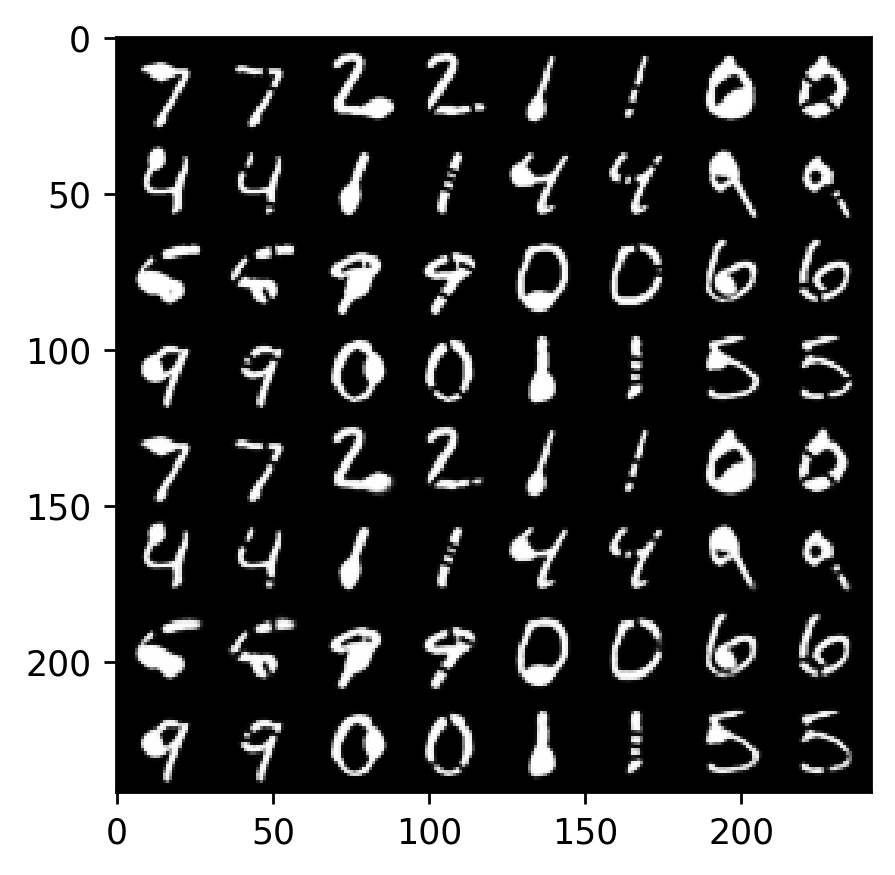

In [3]:
vqvae_exp.show_vqvae_recons(dpi=250)

Loading datamodule...
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Computing TSNE...


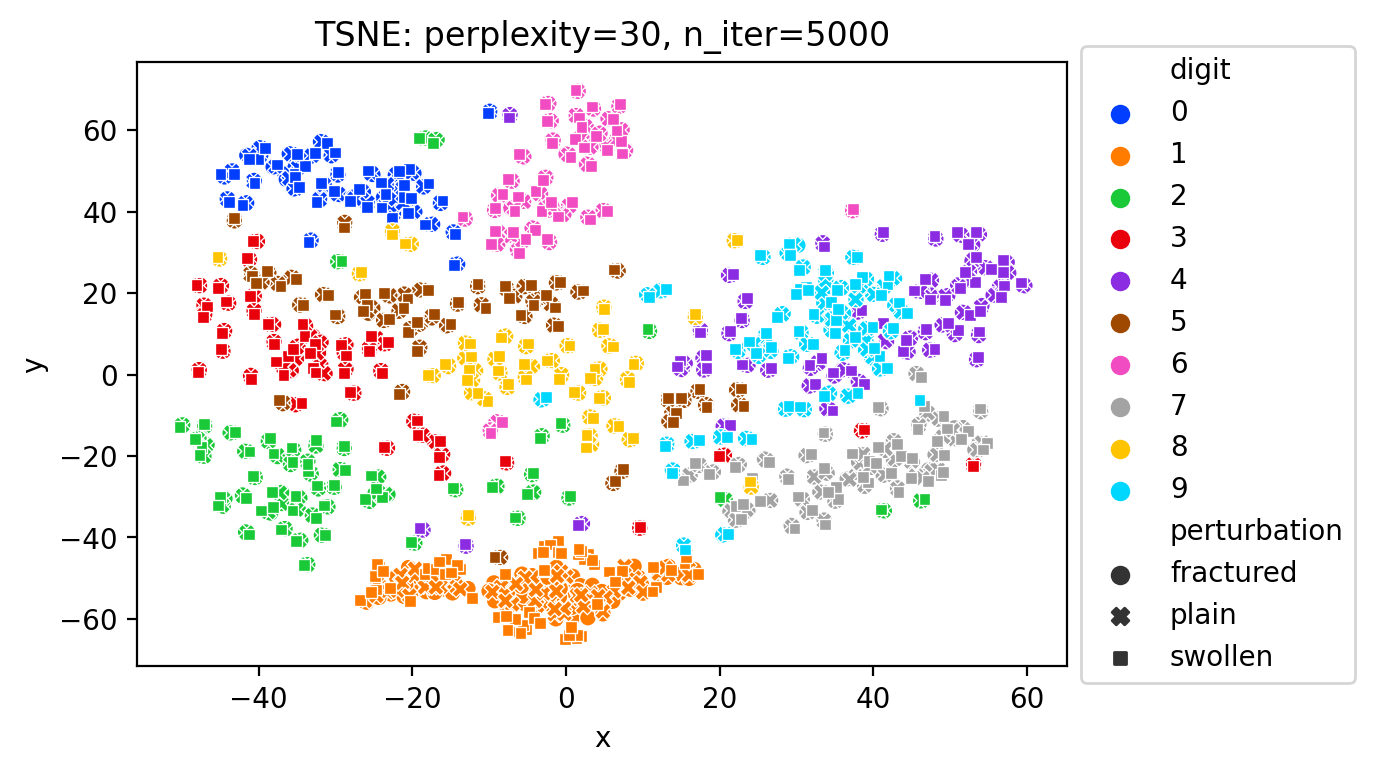

In [4]:
vqvae_exp.plot_vqvae_tsne(perplexity=30, n_iter=5000)

## Example dataset item

In [3]:
from ccbir.data.morphomnist.dataset import PerturbedMorphoMNIST, SwollenMorphoMNIST, FracturedMorphoMNIST, PlainMorphoMNIST
from ccbir.models.twinnet.data import PSFTwinNetDataset
from deepscm.datasets.morphomnist import MorphoMNISTLike
import matplotlib.pyplot as plt
from ccbir.experiment.experiments import show_tensor
from functools import partial
from ccbir.data.dataset import BatchDict
from torchvision import transforms

#test_data_perturbed = FracturedMorphoMNIST(train=True, binarize=False)
#test_data_plain = PlainMorphoMNIST(train=False)
psf_dataset = PSFTwinNetDataset(embed_image=lambda x: x, train=False)
#plain = PlainMorphoMNIST(train=True)

swollen = SwollenMorphoMNIST(train=True)
"""
swollen = SwollenMorphoMNIST(train=True, transform=partial(
                BatchDict.map_feature,
                keys=['image'],
                func=transforms.Normalize(mean=0.5, std=0.5),
            ),)

"""
#print(swollen.get_items().map_feature(['image'], transforms.Normalize(0.5, 0.5)))

#show_tensor(test_data_plain[8]['image'], dpi=50)


"\nswollen = SwollenMorphoMNIST(train=True, transform=partial(\n                BatchDict.map_feature,\n                keys=['image'],\n                func=transforms.Normalize(mean=0.5, std=0.5),\n            ),)\n\n"

In [ ]:
from ccbir.models.twinnet.model import SimpleDeepTwinNetComponent
from torchinfo import summary
import torch

model = SimpleDeepTwinNetComponent(2, 16, 32, torch.Size((16, 7, 7)))
print(f"{model.input_dim=}")
summary(model.network, (64, 2 + 16 + 32))

model.input_dim=50


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [64, 128]                 6,528
├─LeakyReLU: 1-2                         [64, 128]                 --
├─Unflatten: 1-3                         [64, 128, 1, 1]           --
├─ConvTranspose2d: 1-4                   [64, 64, 3, 3]            73,792
├─LeakyReLU: 1-5                         [64, 64, 3, 3]            --
├─ConvTranspose2d: 1-6                   [64, 32, 5, 5]            18,464
├─LeakyReLU: 1-7                         [64, 32, 5, 5]            --
├─ConvTranspose2d: 1-8                   [64, 16, 7, 7]            4,624
Total params: 103,408
Trainable params: 103,408
Non-trainable params: 0
Total mult-adds (M): 86.97
Input size (MB): 0.01
Forward/backward pass size (MB): 1.17
Params size (MB): 0.41
Estimated Total Size (MB): 1.60

In [1]:
from torchinfo import summary
import torch
from torch import nn


def Activation(): return nn.SiLU(inplace=True)

class ResBlock(nn.Module):
    def __init__(self, dim, activation=lambda: nn.ReLU(True)):
        super().__init__()
        self.block = nn.Sequential(
            activation(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            activation(),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


dim = 16 * 7 * 7
print('Works')
net = nn.Sequential(
    nn.Unflatten(1, (-1, 1, 1)),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    nn.LazyConvTranspose2d(128, 3),
    ResBlock(128),
    ResBlock(128),
    ResBlock(128),
    nn.LazyConv2d(2, 2),
)
input_shape = (64, 2 + 16 + 32)
print(f"{input_shape=}")
summary(net, input_shape)

Works
input_shape=(64, 50)


/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
from ccbir.experiment.experiments import PSFTwinNetExperiment
from ccbir.models.vqvae.model import VQVAE
from ccbir.models.twinnet.model import PSFTwinNet
from ccbir.models.util import load_best_model, best_model_checkpoint_path
import torch

vqvae = load_best_model(VQVAE)
checkpoint = torch.load(best_model_checkpoint_path(VQVAE))
print(f"{checkpoint=}")

twinnet = PSFTwinNet.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_113/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_75/checkpoints/last.ckpt'
    #'/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_66/checkpoints/last.ckpt'
)

exp = PSFTwinNetExperiment(
    vqvae=vqvae,
    twinnet=twinnet,
)


Loaded <class 'ccbir.models.vqvae.model.VQVAE'> from path=PosixPath('/homes/mb8318/Documents/year4/ccbir/assets/checkpoints/vqvae/best.ckpt')
checkpoint={'epoch': 1100, 'global_step': 1858488, 'pytorch-lightning_version': '1.6.0', 'state_dict': OrderedDict([('model.encoder.0.weight', tensor([[[[ 0.0856,  0.2470,  0.3144,  0.0997],
          [-0.2437, -0.5268, -0.4717, -0.1487],
          [ 0.1058,  0.3240,  0.1585,  0.0377],
          [-0.0082,  0.0024,  0.0042,  0.0026]]],


        [[[ 0.1238,  0.0720,  0.1147, -0.0320],
          [ 0.0818, -0.5172, -0.1494,  0.1700],
          [-0.3762, -1.0563, -0.5354,  0.0939],
          [ 0.0176, -0.3606, -0.0211,  0.1672]]],


        [[[ 0.3087,  0.2446,  0.2689,  0.1214],
          [ 0.3770,  0.2367,  0.0411, -0.0085],
          [ 0.4291,  0.3002,  0.2490,  0.1433],
          [-0.0088, -0.2166,  0.3311,  0.2124]]],


        ...,


        [[[-0.3008, -0.0918, -0.0415, -0.1186],
          [-0.1021,  0.1760,  0.4426, -0.0190],
          [-0.38

/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loading datamodule...
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
Loading dataset from cache
swollen_embedding.shape=torch.Size([1, 2, 8, 8])
fractured_embedding.shape=torch.Size([1, 2, 8, 8])
original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs
swollen_embedding.shape=torch.Size([1, 2, 8, 8])
fractured_embedding.shape=torch.Size([1, 2, 8, 8])
original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs
swollen_embedding.shape=torch.Size([1, 2, 8, 8])
fractured_embedding.shape=torch.Size([1, 2, 8, 8])
original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs
swollen_embedding.shape=torch.Size([1, 2, 8, 8])
fractured_embedding.shape=torch.Size([1, 2, 8, 8])
original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs
swollen_embedding.shape=torch.Size([1,

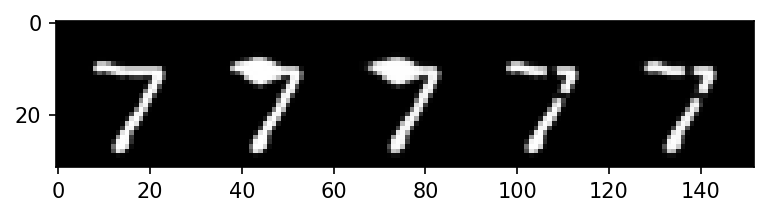

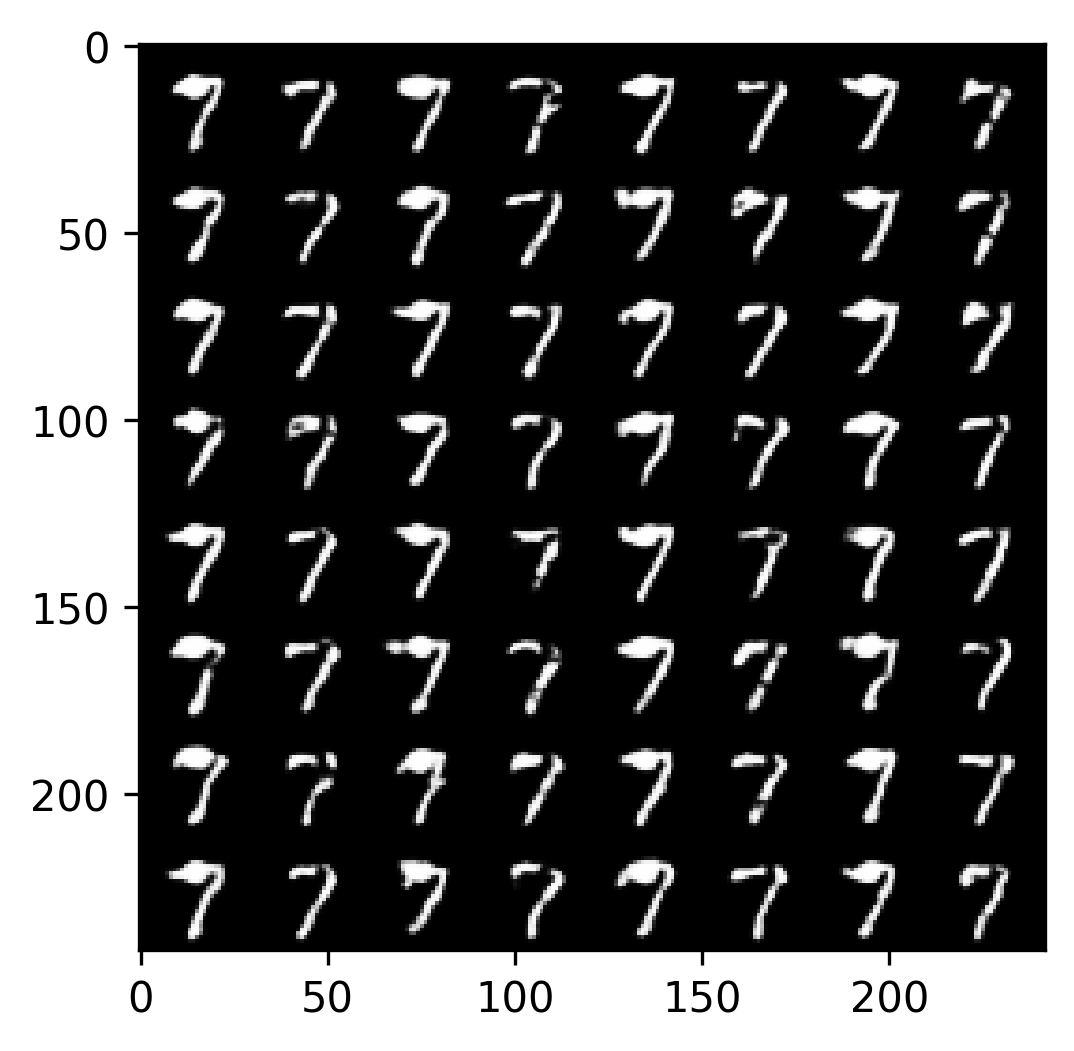

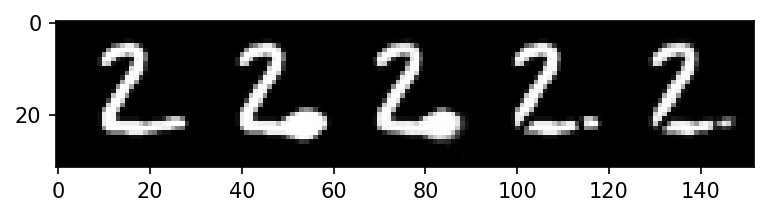

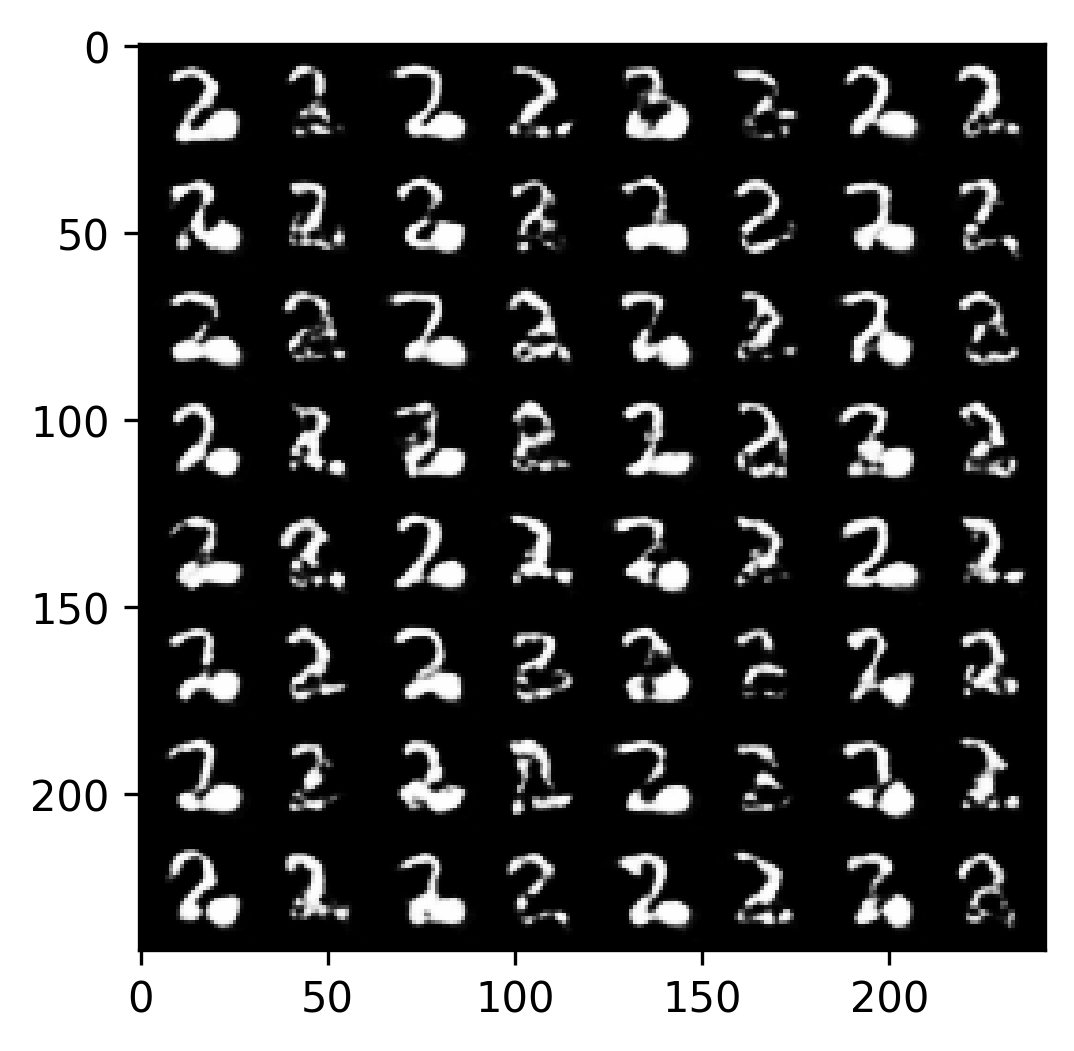

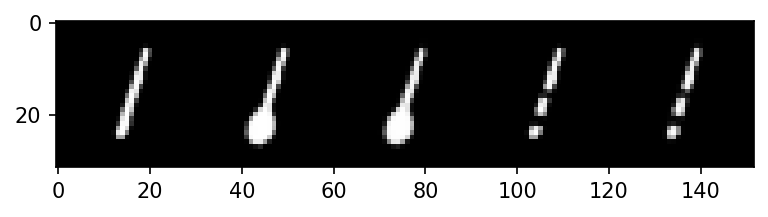

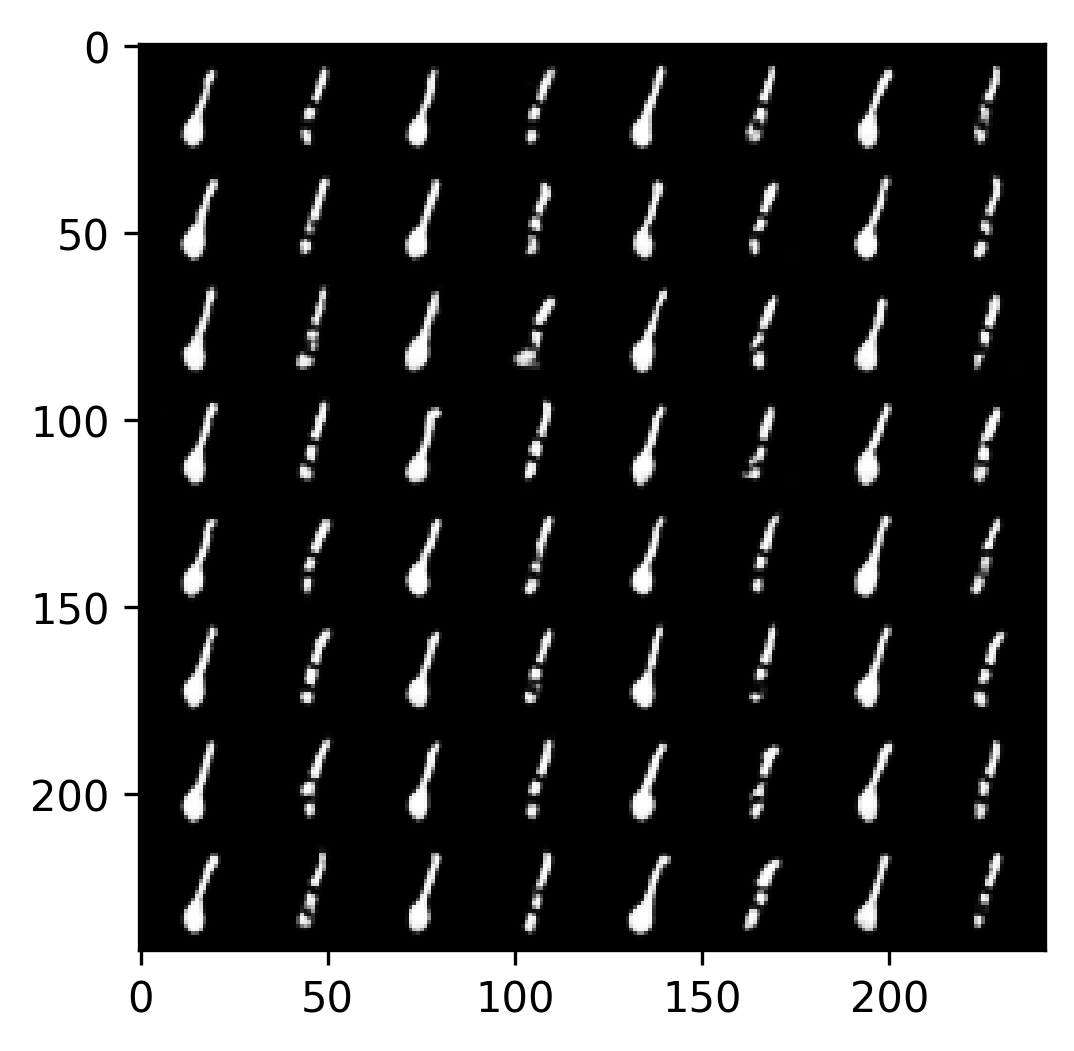

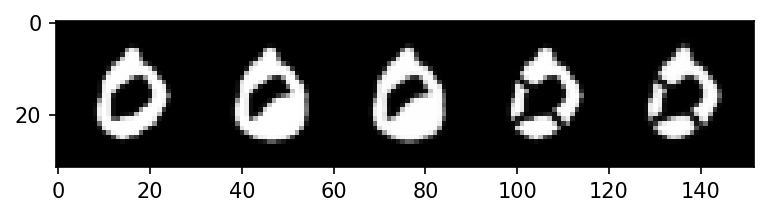

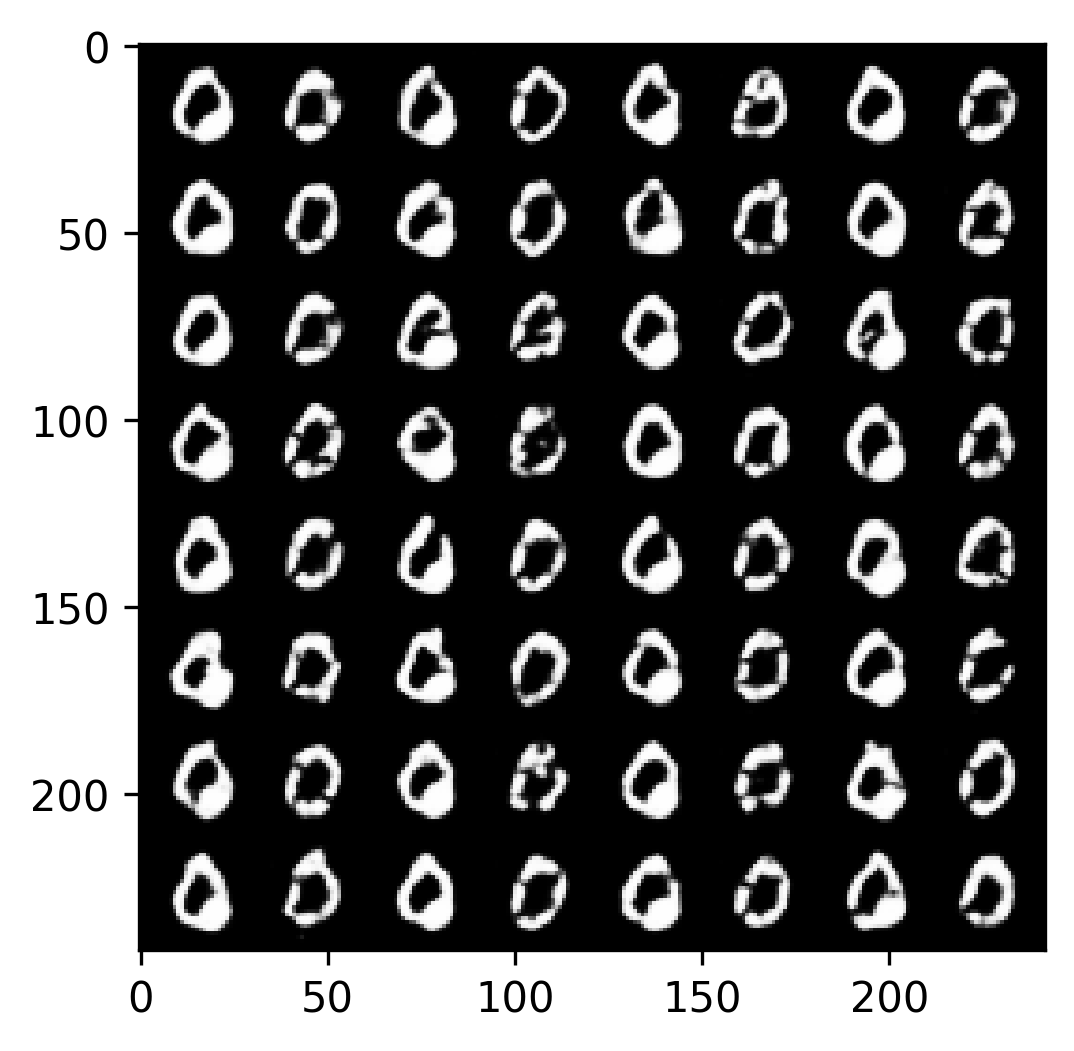

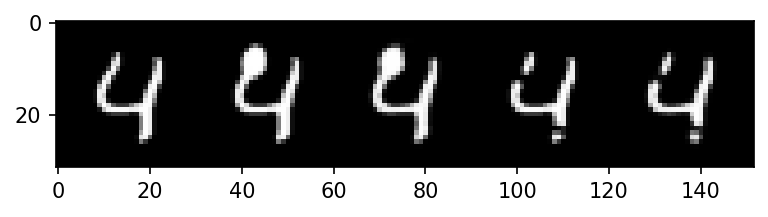

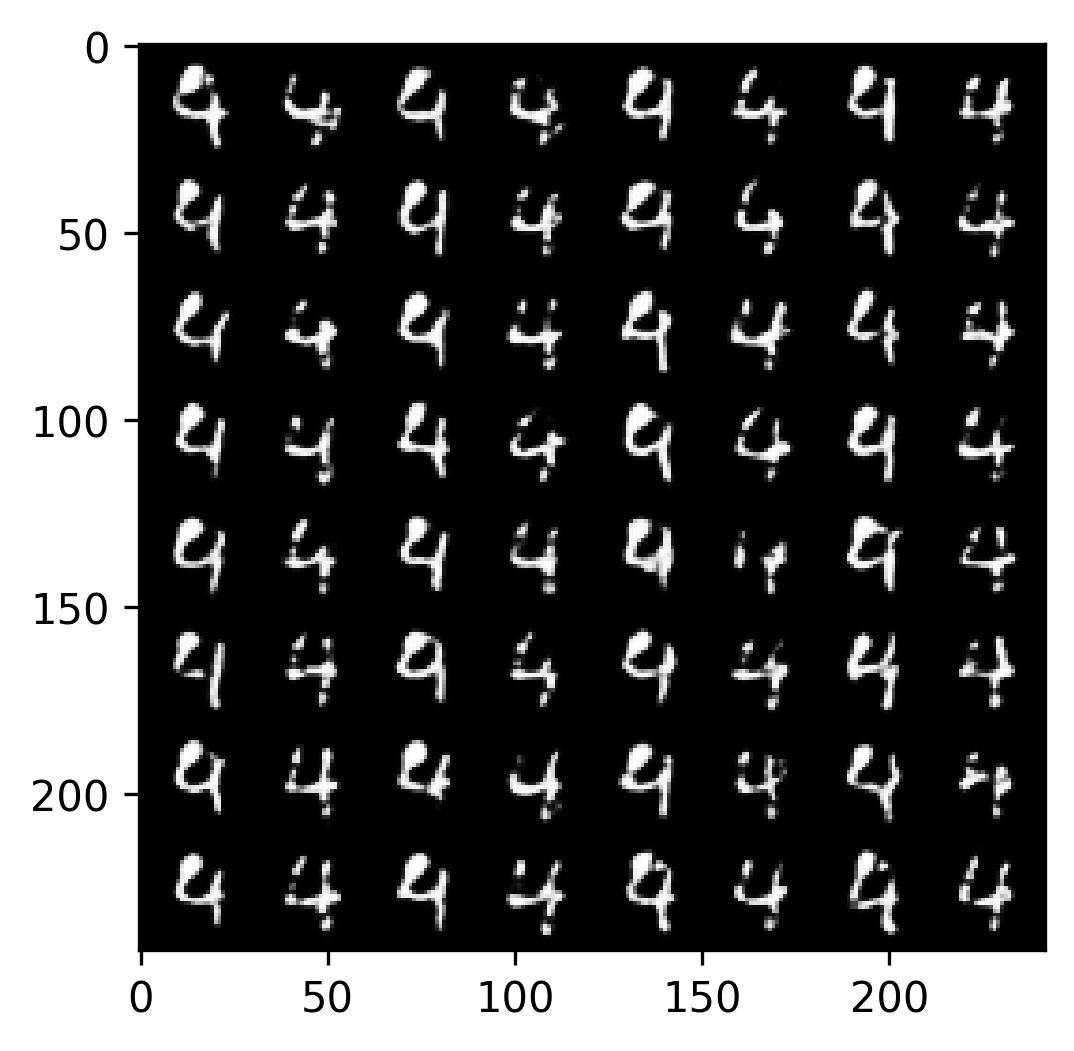

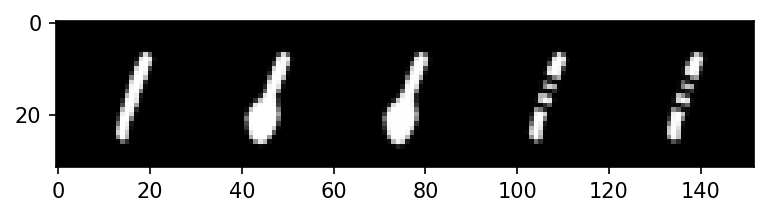

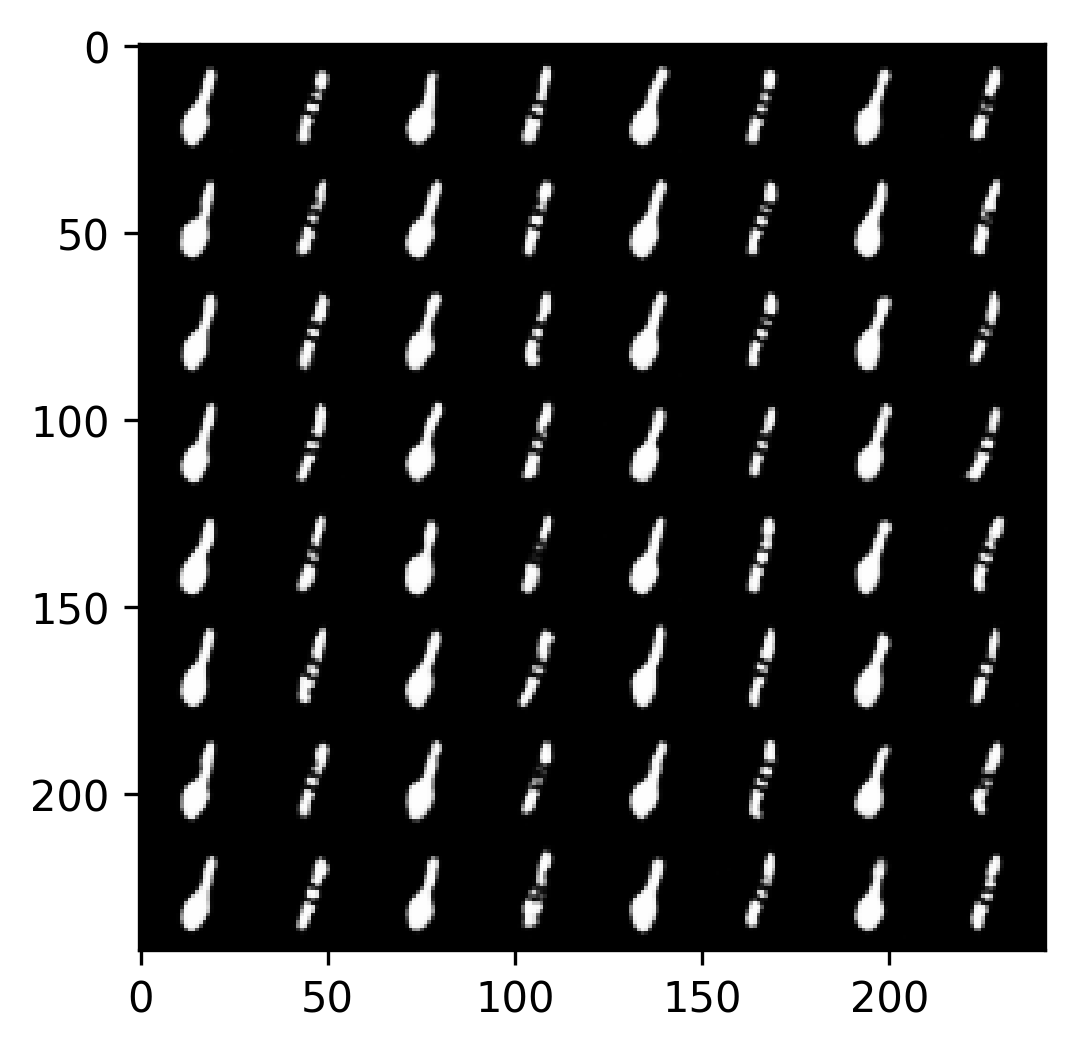

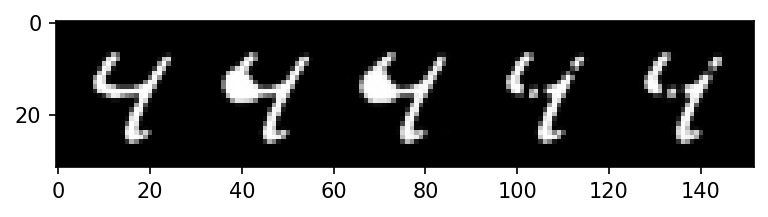

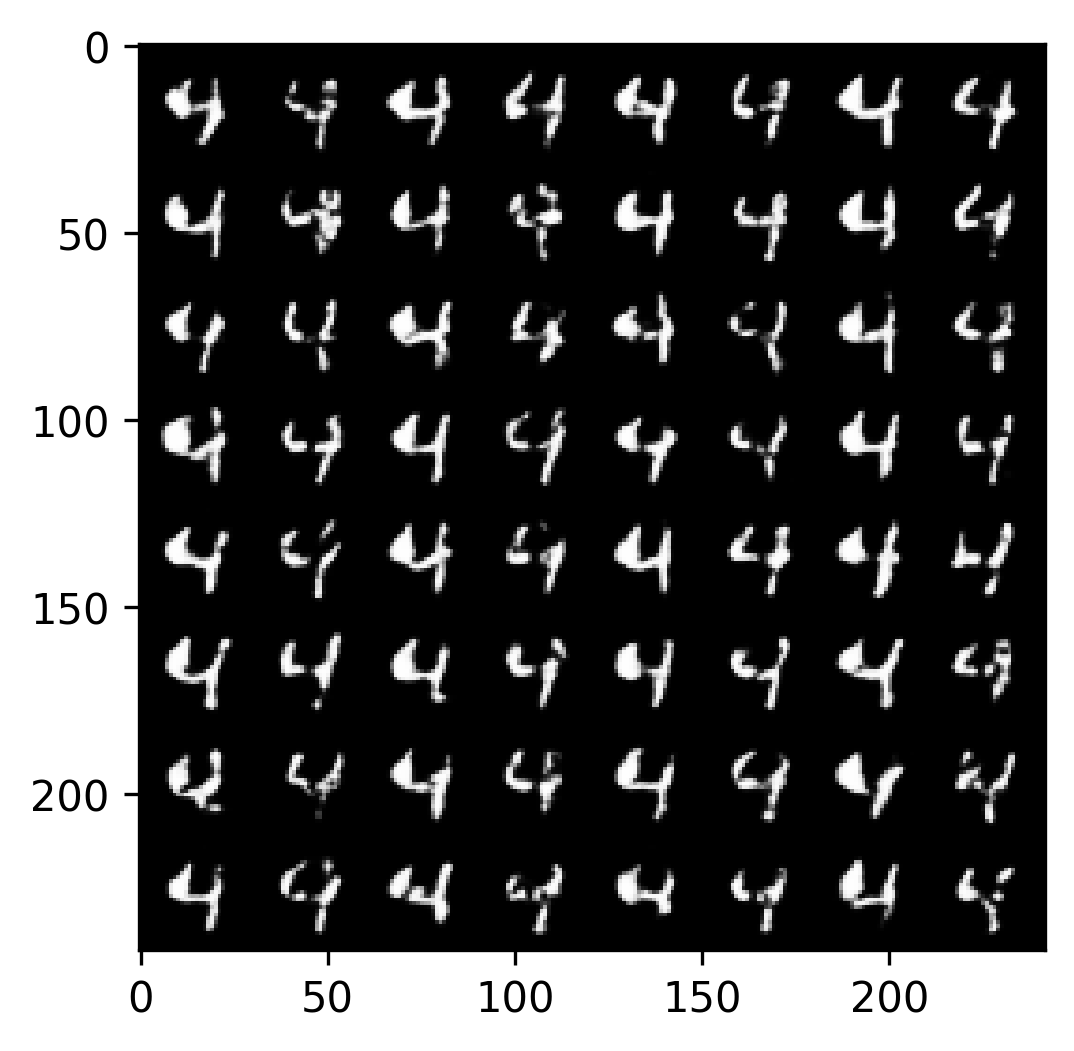

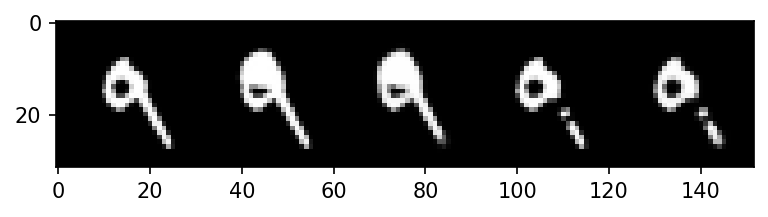

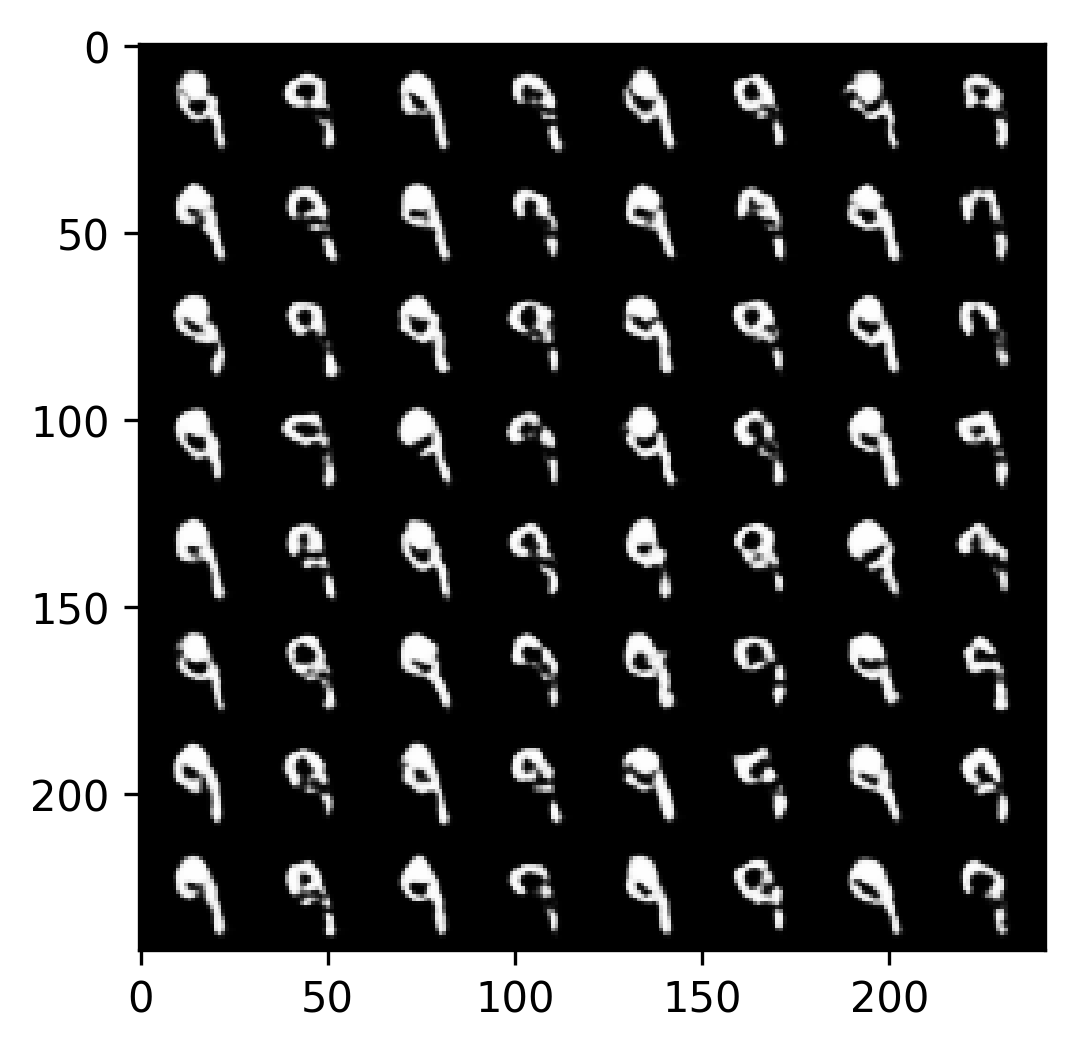

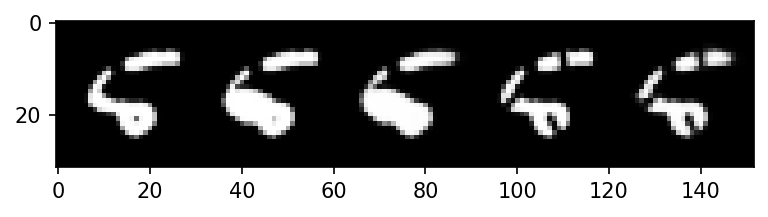

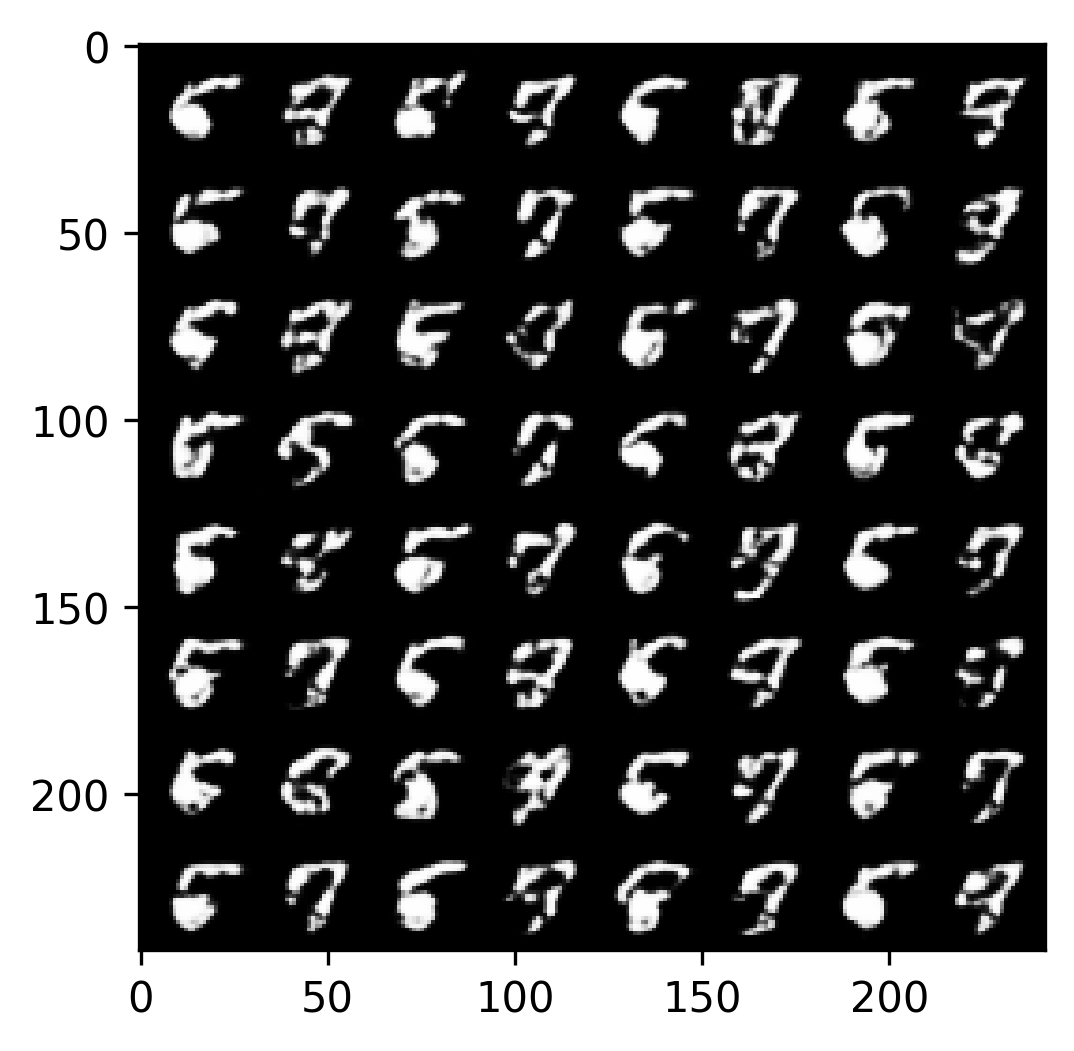

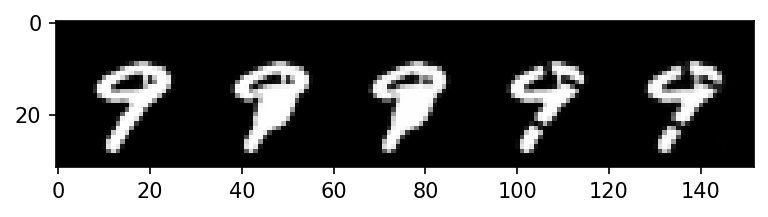

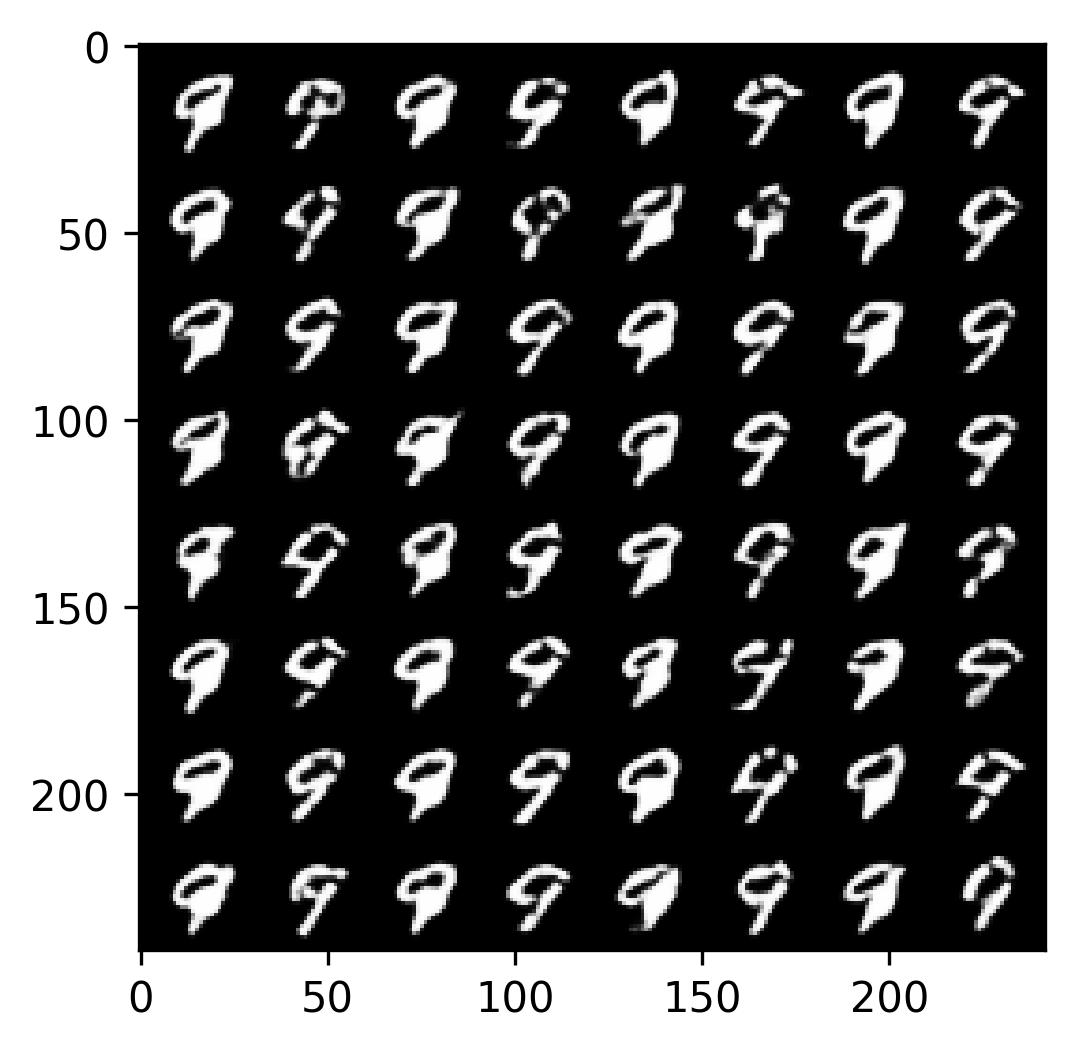

In [6]:
# 1, 35


for sample_idx in range(10):
    exp.show_twinnet_samples(sample_idx, noise_scale=0.25, num_samples=32, train=False)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


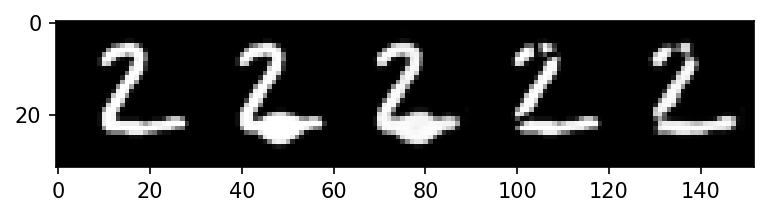

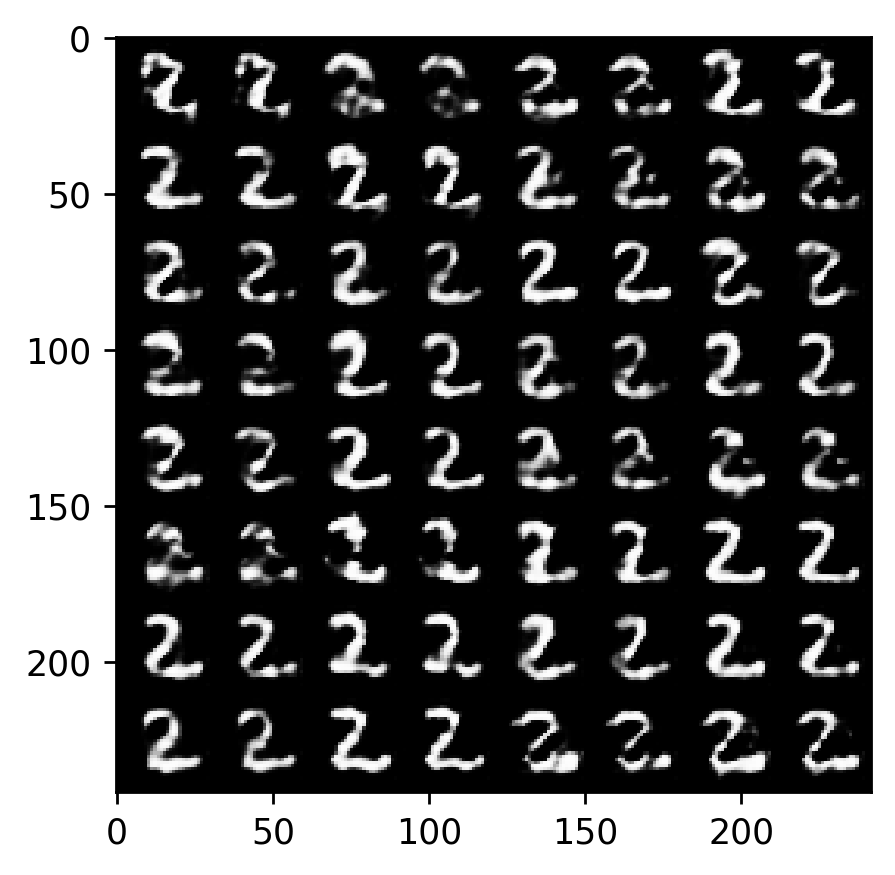

In [39]:
exp.show_twinnet_samples(1)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


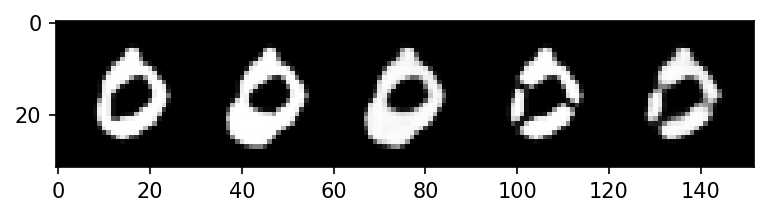

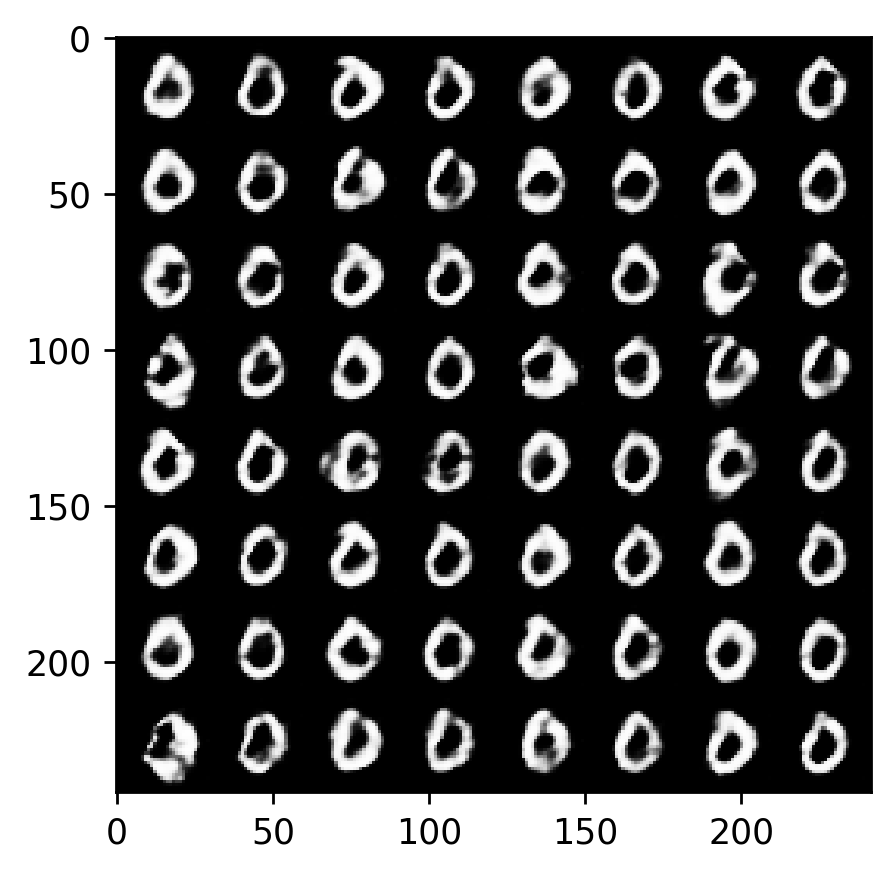

In [32]:
exp.show_twinnet_samples(3)

original, swollen, swollen_vqvae, fractured, fractured_vqvae
Twin network outputted swollen-fractured pairs


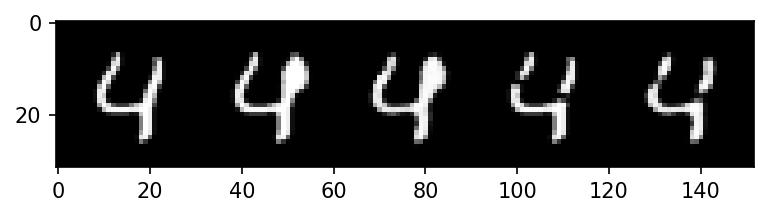

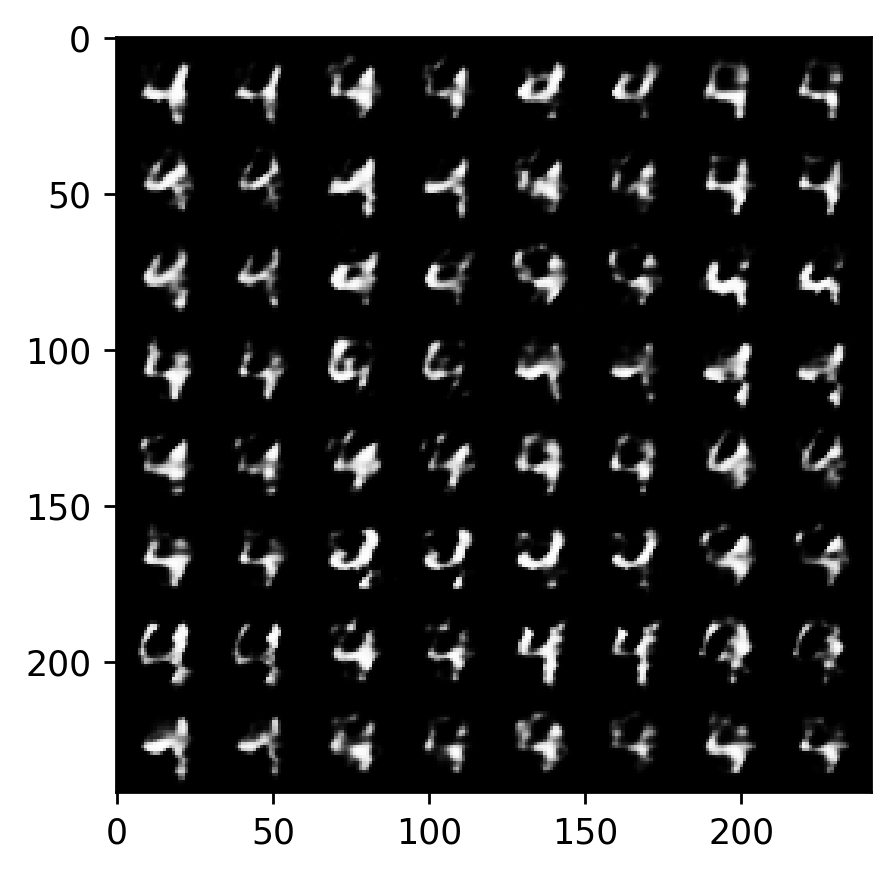

In [33]:
exp.show_twinnet_samples(4)

Computing TSNE...


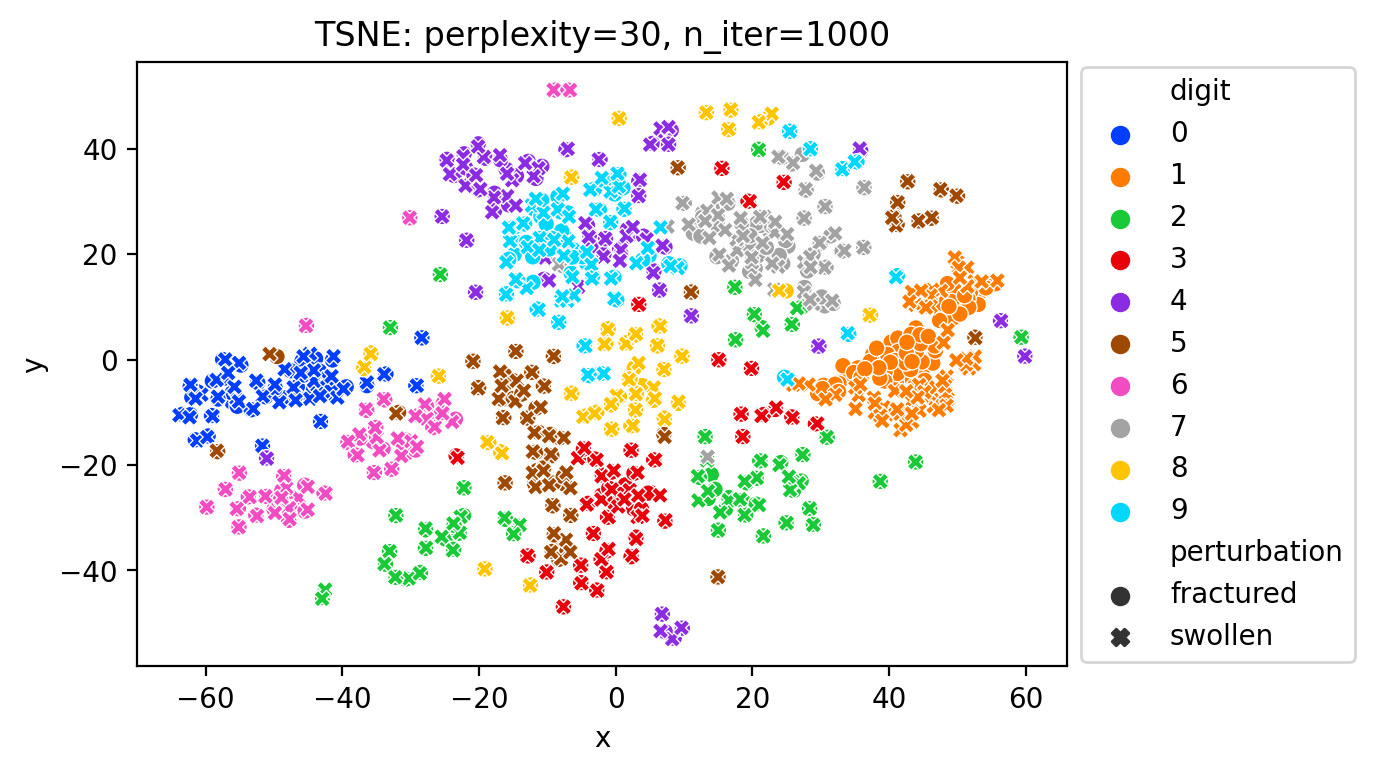

In [12]:
vqvae_exp.plot_vqvae_tsne(include_perturbations=['swollen', 'fractured'])

Computing TSNE...


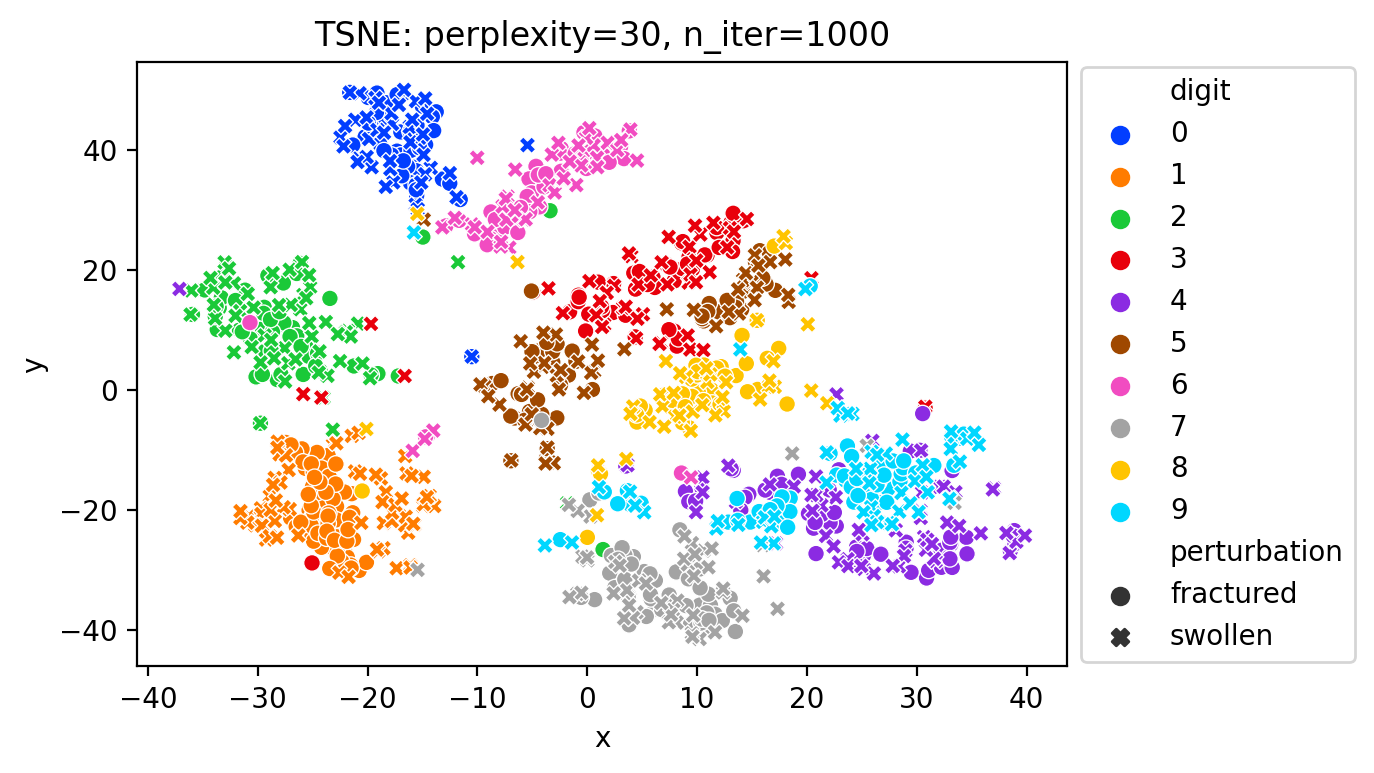

In [9]:
exp.plot_twinnet_tsne()